Load the three data files.

In [1]:
import pandas as pd
import os

PATH_CSV = '/kaggle/input/demand-forecasting-with-tabular-textual-images/beach_demand_forecast'

df_sales = pd.read_csv(os.path.join(PATH_CSV,"sales_train.csv"))
df_items = pd.read_csv(os.path.join(PATH_CSV,"items.csv"))
df_resturant = pd.read_csv(os.path.join(PATH_CSV,"resturants.csv"))

Utility function to create sequences.

In [2]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Join the items and sales tables so that we can look up the store id for each item.

In [3]:
df_items2 = df_items[['id','store_id']]
df_train = df_sales.merge(df_items2,left_on='item_id',right_on='id')
df_train[['date','item_id','item_count','store_id']]

df_train = df_train.sort_values('date').groupby(['item_id', 'store_id', 'date'], as_index=False)
df_train = df_train.agg({'item_count':['mean']})
df_train.columns = ['item', 'store', 'date', 'sales']
df_train.head()

,item,store,date,sales
0,1,4,2019-01-01,0.0
1,1,4,2019-01-02,0.0
2,1,4,2019-01-03,0.0
3,1,4,2019-01-04,0.0
4,1,4,2019-01-05,0.0


Build the sequence data.

In [4]:
window = 29
future_span = 30
series = series_to_supervised(df_train.drop('date', axis=1), window=window, lag=future_span)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+30),store(t+30),sales(t+30)
29,1.0,4.0,0.0,1.0,4.0,0.0,1.0,4.0,0.0,1.0,...,0.0,1.0,4.0,0.0,1,4,0.0,1.0,4.0,0.0
30,1.0,4.0,0.0,1.0,4.0,0.0,1.0,4.0,0.0,1.0,...,0.0,1.0,4.0,0.0,1,4,0.0,1.0,4.0,0.0
31,1.0,4.0,0.0,1.0,4.0,0.0,1.0,4.0,0.0,1.0,...,0.0,1.0,4.0,0.0,1,4,0.0,1.0,4.0,0.0
32,1.0,4.0,0.0,1.0,4.0,0.0,1.0,4.0,0.0,1.0,...,0.0,1.0,4.0,0.0,1,4,0.0,1.0,4.0,0.0
33,1.0,4.0,0.0,1.0,4.0,0.0,1.0,4.0,0.0,1.0,...,0.0,1.0,4.0,0.0,1,4,0.0,1.0,4.0,0.0


Remove sequences that did not have enough data.

In [5]:
# Remove edge cases, where there were not enough values to complete a series
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

We will just predict using the sales column.

In [6]:
# Remove all but the sales column
columns_to_drop = [('%s(t+%d)' % (col, future_span)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

Extract the predictors (x sequences) and the label (future prediction)

In [7]:
from sklearn.model_selection import train_test_split

# Label
labels_col = 'sales(t+%d)' % future_span
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (64002, 30)
Validation set shape (42668, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
12343,9.0,9.0,5.0,7.0,11.0,10.0,11.0,7.0,6.0,12.0,...,11.0,7.0,8.0,9.0,11.0,13.0,13.0,5.0,6.0,9.0
52950,0.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,3.0,0.0,3.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0
95189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79104,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0
24964,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0


Final preparation for the x and y.

In [8]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (64002, 30, 1)
Validation set shape (42668, 30, 1)


Construct the neural network.

In [9]:
import tensorflow as tf 
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
import keras

epochs = 500 
batch = 256
lr = 0.0003
adam = tf.keras.optimizers.Adam(lr)

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=8, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 23, 64)            576       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 704)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                35250     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 35,877
Trainable params: 35,877
Non-trainable params: 0
____________________________________________________

2022-12-02 01:06:43.583765: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Fit the neural network.

In [10]:
from keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

cnn_history = model_cnn.fit(X_train_series, Y_train, callbacks=[monitor],
    validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

2022-12-02 01:06:43.795854: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
2001/2001 - 10s - loss: 146.3715 - val_loss: 92.6879
Epoch 2/500
2001/2001 - 10s - loss: 122.4579 - val_loss: 85.9790
Epoch 3/500
2001/2001 - 10s - loss: 115.2138 - val_loss: 91.6094
Epoch 4/500
2001/2001 - 9s - loss: 115.3943 - val_loss: 83.7931
Epoch 5/500
2001/2001 - 10s - loss: 113.4380 - val_loss: 83.2139
Epoch 6/500
2001/2001 - 10s - loss: 113.4369 - val_loss: 93.3592
Epoch 7/500
2001/2001 - 10s - loss: 108.8707 - val_loss: 85.9756
Epoch 8/500
2001/2001 - 9s - loss: 107.8114 - val_loss: 83.0421
Epoch 9/500
2001/2001 - 9s - loss: 108.9351 - val_loss: 83.8303
Epoch 10/500
2001/2001 - 10s - loss: 104.5708 - val_loss: 85.8060
Epoch 11/500
2001/2001 - 9s - loss: 99.9689 - val_loss: 97.2626
Epoch 12/500
2001/2001 - 9s - loss: 99.8189 - val_loss: 89.5939
Epoch 13/500
2001/2001 - 10s - loss: 103.7129 - val_loss: 80.0374
Epoch 14/500
2001/2001 - 10s - loss: 100.6198 - val_loss: 78.2155
Epoch 15/500
2001/2001 - 9s - loss: 101.6247 - val_loss: 82.6331
Epoch 16/500
2001/2001 - 10

Predict and evaluate the validation data.

In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

Train rmse: 7.429230543316075
Validation rmse: 8.034572137422316


Plot the training curve.

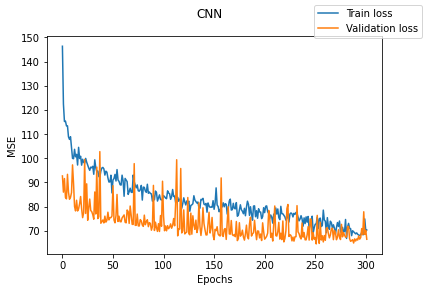

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
fig.legend()
fig.suptitle('CNN')
plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.show()